In [1]:
gpu=6
CUDA_VISIBLE_DEVICES=gpu
!nvidia-smi

Tue Jan  4 22:32:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 51%   82C    P2   198W / 250W |   8063MiB / 11178MiB |     98%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 32%   66C    P2   156W / 250W |   9385MiB / 11178MiB |     90%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import numpy as np
import pandas as pd

# import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

# import osa
import shutil

In [3]:
import seaborn as sns
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
from glob import glob
from sklearn.metrics import roc_curve,auc, precision_score,precision_recall_curve,recall_score,precision_recall_fscore_support,confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import models
from prettytable import PrettyTable
print(torch.cuda.is_available())
import warnings
warnings.filterwarnings("ignore")
# import pandas as pd
print(torch.cuda.get_device_properties(0).total_memory)
print(torch.cuda.memory_allocated())
gpu_id = gpu

True
11721506816
0


In [8]:
# train_df=pd.read_csv("/DATA/chowdari1/DATA/csv/nih_train.csv")
# test_df=pd.read_csv("/DATA/chowdari1/DATA/csv/nih_test.csv")

In [9]:
train_df=pd.read_csv("/DATA/chowdari1/DATA/csv/ppr_nih_train.csv")
test_df=pd.read_csv("/DATA/chowdari1/DATA/csv/ppr_nih_test.csv")
val_df=pd.read_csv("/DATA/chowdari1/DATA/csv/ppr_nih_val.csv")

In [10]:
val_df.head()

,Unnamed: 0,Image index,target,path
0,0,00000009_000.png,1,/DATA/chowdari1/DATA/dataset/nih/images_001/im...
1,1,00000071_004.png,1,/DATA/chowdari1/DATA/dataset/nih/images_001/im...
2,2,00000071_006.png,1,/DATA/chowdari1/DATA/dataset/nih/images_001/im...
3,3,00000099_000.png,1,/DATA/chowdari1/DATA/dataset/nih/images_001/im...
4,4,00000099_001.png,1,/DATA/chowdari1/DATA/dataset/nih/images_001/im...


In [11]:
train_df=train_df.sample(frac=1)

In [12]:
train_df.head()

,Unnamed: 0,Image index,target,path
6565,6565,00020286_002.png,1,/DATA/chowdari1/DATA/dataset/nih/images_009/im...
7209,7209,00022267_004.png,1,/DATA/chowdari1/DATA/dataset/nih/images_010/im...
3419,3419,00012210_004.png,0,/DATA/chowdari1/DATA/dataset/nih/images_006/im...
48,48,00000184_001.png,0,/DATA/chowdari1/DATA/dataset/nih/images_001/im...
6100,6100,00019006_003.png,1,/DATA/chowdari1/DATA/dataset/nih/images_009/im...


In [13]:
train_df.shape

(8574, 4)

In [14]:
train_df["target"].value_counts()

1    4313
0    4261
Name: target, dtype: int64

In [15]:
val_df["target"].value_counts()

1    857
0    849
Name: target, dtype: int64

In [16]:
test_df["target"].value_counts()

0    677
1    667
Name: target, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

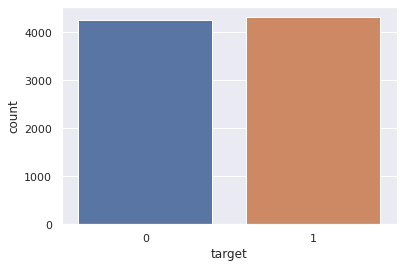

In [17]:
#Countplot
sns.set_theme(style="darkgrid")
sns.countplot(x="target", data=train_df.iloc[:])

In [18]:
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir, transform,start,count):
        self.ipaths = df["path"][start:count].to_numpy()
        self.target=df["target"][start:count].to_numpy()
        self.transform = transform
        self.count=count
        self.img_dir=img_dir


    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        img_path=self.img_dir+self.ipaths[idx]
        image = Image.open(img_path).convert('RGB')
        label=self.target[idx]
        image = self.transform(image)
        return image,label

In [19]:
normalizer=[[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
transformations = {
		'train': transforms.Compose([
			transforms.Resize(256),
			transforms.CenterCrop(224),
			transforms.RandomHorizontalFlip(),
			transforms.ColorJitter(brightness=0.25, contrast=0.25),
			transforms.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
			transforms.ToTensor(),
			transforms.Normalize(normalizer[0], normalizer[1])]),
		'val': transforms.Compose([
			transforms.Resize(256),
			transforms.CenterCrop(224),
			transforms.ToTensor(),
			transforms.Normalize(normalizer[0], normalizer[1])]),
		'test': transforms.Compose([
		transforms.Resize(256),
		transforms.CenterCrop(224),
		transforms.ToTensor(),
		transforms.Normalize(normalizer[0], normalizer[1])])	
			}


In [20]:
train_data=CustomImageDataset(train_df,'',transformations["train"],0,train_df.shape[0])
valid_data=CustomImageDataset(val_df,'',transformations["val"],0,val_df.shape[0])
test_data=CustomImageDataset(test_df,'',transformations["test"],0,test_df.shape[0])
print(len(train_data))
print(len(test_data))
trainloader=torch.utils.data.DataLoader(train_data, batch_size=64)
valloader=torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader=torch.utils.data.DataLoader(test_data, batch_size=64)
print(trainloader)
print(len(testloader))
dataloaders = {"train":trainloader, "val":valloader, "test": testloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val','test']}
data_sizes

8574
1344
21


{'train': 8574, 'val': 1706, 'test': 1344}

In [21]:
import torch
torch.cuda.empty_cache()
device=torch.device("cuda:6")
print("Training on GPU... Ready for HyperJump...")

Training on GPU... Ready for HyperJump...


In [22]:
torch.cuda.set_device(gpu)

In [23]:
def densenet_Model(pretrained=True):
    model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(num_ftrs, 1) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model

model = densenet_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.BCEWithLogitsLoss(reduction='mean').cuda()

# Specify optimizer which performs Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=0.0001, momentum=0.9)		

# Learning Scheduler
exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience = 5)



In [24]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6954881


In [26]:
from sklearn.metrics import roc_auc_score
def epoch_train(model,optimizer, criterion):
    model.train()
    loss_train = 0
    loss_train_norm = 0
    loss_tensor_mean_train = 0
    output_list = []
    label_list = []
    phase="train"
    for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
        inputs = inputs.to(device, non_blocking=True)
        # labels = labels.type(torch.FloatTensor) 
        labels = labels.to(device, non_blocking=True)
        labels = labels.view(labels.size()[0],-1)

        optimizer.zero_grad()			
        outputs = model(inputs)
        # _, preds = torch.max(outputs.data, 1)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
            score = torch.sigmoid(outputs)
        else:
            score = torch.sigmoid(outputs)
        preds = score>0.5
        preds = preds.type(torch.cuda.LongTensor)
        
        labels = labels.type(torch.cuda.FloatTensor) #add for BCE loss
        loss = criterion(outputs, labels)
        loss_tensor_mean_train += loss

        labels = labels.data.cpu().numpy()
        outputs = outputs.data.cpu().numpy()

        for i in range(outputs.shape[0]):
            output_list.append(outputs[i].tolist())
            label_list.append(labels[i].tolist())

        loss_train_norm += 1
        loss.backward()
        optimizer.step()
    loss_tensor_mean_train = np.float(loss_tensor_mean_train) / loss_train_norm
    epoch_auc =  roc_auc_score(np.array(label_list), np.array(output_list))
    output_list = []
    label_list = []
    return loss_tensor_mean_train, epoch_auc



In [27]:
def epoch_val(model, criterion):
    model.eval()
    loss_val = 0
    loss_val_norm = 0
    loss_tensor_mean_val = 0
    # running_corrects = 0
    output_list = []
    label_list = []
    phase='val'
    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
            labels = labels.type(torch.FloatTensor) #add for BCE loss
            inputs = inputs.cuda(gpu_id, non_blocking=True)
            labels = labels.cuda(gpu_id, non_blocking=True)
            labels = labels.view(labels.size()[0],-1) #add for BCE loss

            outputs = model(inputs)
            loss_tensor = criterion(outputs, labels)
            loss_tensor_mean_val += loss_tensor
            
            labels = labels.data.cpu().numpy()
            outputs = outputs.data.cpu().numpy()

            for i in range(outputs.shape[0]):
                output_list.append(outputs[i].tolist())
                label_list.append(labels[i].tolist())
            loss_val_norm += 1
    loss_tensor_mean_val = np.float(loss_tensor_mean_val) / loss_val_norm
    epoch_auc =  roc_auc_score(np.array(label_list), np.array(output_list))
    output_list = []
    label_list = []
    return loss_tensor_mean_val, epoch_auc

    

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epoch=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    loss_min = np.inf

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print('-' * 10)

        loss_train, auc_train = epoch_train(model, optimizer, criterion)
        loss_val, auc_val=epoch_val(model,criterion)

        scheduler.step(loss_val)
        if loss_val < loss_min:
            print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(loss_min, loss_val))
            loss_min=loss_val
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

        print ('*'*20)	
        print ('Train_AUC: {:.4f}     Train_loss: {:.4f}'\
            .format(auc_train, loss_train))
        print ('  Val_AUC: {:.4f}     Val_loss: {:.4f}'\
            .format(auc_val, loss_val))
        print ('\n')
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(loss_min))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model
    
        

In [29]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [30]:
train_df=pd.DataFrame()
test_df=pd.DataFrame()
val_df=pd.DataFrame()
# testloader=[]

In [31]:
torch.cuda.empty_cache()

In [64]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epoch=2)

Epoch 1/2
----------


Val loss Decreased from inf to 0.4355 
Saving Weights... 

********************
Train_AUC: 0.8675     Train_loss: 0.4602
  Val_AUC: 0.9136     Val_loss: 0.4355


Epoch 2/2
----------


Val loss Decreased from 0.4355 to 0.3884 
Saving Weights... 

********************
Train_AUC: 0.9125     Train_loss: 0.3660
  Val_AUC: 0.9211     Val_loss: 0.3884


Training complete in 13m 33s
Best val loss: 0.3884


In [66]:
path="/DATA/chowdari1/saved_models/nih_ppr_gold(2epoch).pth"
torch.save(base_model.state_dict(), path)

## Test

In [32]:
import datetime
now = datetime. datetime. now()
from sklearn import metrics
def test(model,dataloader):
    print (datetime. datetime. now())
    model.eval()
    running_corrects = 0
    output_list =[]
    label_list = []
    preds_list = []
    phase='test'
    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(dataloader, leave=False):
            labels_auc = labels
            labels_print = labels
            labels_auc = labels_auc.type(torch.FloatTensor)
            labels = labels.type(torch.LongTensor) #add for BCE loss
            inputs = inputs.cuda(gpu_id, non_blocking=True)
            labels = labels.cuda(gpu_id, non_blocking=True)
            labels_auc = labels_auc.cuda(gpu_id, non_blocking=True)

            labels = labels.view(labels.size()[0],-1) #add for BCE loss
            labels_auc = labels_auc.view(labels_auc.size()[0],-1) #add for BCE loss
            # forward
            outputs = model(inputs)
            # _, preds = torch.max(outputs.data, 1)
            score = torch.sigmoid(outputs)
            score_np = score.data.cpu().numpy()
            preds = score>0.5
            preds_np = preds.data.cpu().numpy()
            preds = preds.type(torch.cuda.LongTensor)

            labels_auc = labels_auc.data.cpu().numpy()
            outputs = outputs.data.cpu().numpy()
            for i in range(outputs.shape[0]):
                output_list.append(outputs[i].tolist())
                label_list.append(labels_auc[i].tolist())
                preds_list.append(preds_np[i].tolist())
            running_corrects += torch.sum(preds.data == labels.data) #add for BCE loss
    data_size=len(dataloader.sampler)
    acc = np.float(running_corrects) / data_size
    auc = metrics.roc_auc_score(np.array(label_list), np.array(output_list), average=None)
    # print(auc)
    fpr, tpr, _ = metrics.roc_curve(np.array(label_list), np.array(output_list))
    roc_auc = metrics.auc(fpr, tpr)

    ap = metrics.average_precision_score(np.array(label_list), np.array(output_list))

    tn, fp, fn, tp = metrics.confusion_matrix(label_list, preds_list).ravel()

    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1 = 2*precision*recall/(precision+recall)
    sensitivity = recall
    specificity = tn/(tn+fp)
    PPV = tp/(tp+fp)
    NPV = tn/(tn+fn)

    print(classification_report(label_list,preds_list))
    print('Test Accuracy: {0:.4f}  Test AUC: {1:.4f}  Test_AP: {2:.4f}'.format(acc, auc, ap))
    print('TP: {0:}  FP: {1:}  TN: {2:}  FN: {3:}'.format(tp, fp, tn, fn))
    print('Sensitivity: {0:.4f}  Specificity: {1:.4f}'.format(sensitivity, specificity))
    print('Precision: {0:.2f}%  Recall: {1:.2f}%  F1: {2:.4f}'.format(precision*100, recall*100, f1))
    print('PPV: {0:.4f}  NPV: {1:.4f}'.format(PPV, NPV))
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve of abnormal/normal classification: ')
    plt.legend(loc="lower right")
    # plt.savefig('ROC_abnormal_normal_cls_'+args.arch+'_'+args.test_labels+'.pdf', bbox_inches='tight')
    plt.show()
    return fpr,tpr

In [34]:
path='/DATA/chowdari1/saved_models/nih_gold(100epoch).pth'
model=densenet_Model(pretrained=True)
x_model=torch.load(path,map_location='cpu')
# x_model=x_model.to(device)
model.load_state_dict(x_model)
model=model.to(device)
model.eval()
print(path)

/DATA/chowdari1/saved_models/nih_gold(100epoch).pth


2021-12-31 19:10:31.791616


              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90       677
         1.0       0.91      0.87      0.89       667

    accuracy                           0.89      1344
   macro avg       0.89      0.89      0.89      1344
weighted avg       0.89      0.89      0.89      1344

Test Accuracy: 0.8936  Test AUC: 0.9486  Test_AP: 0.9617
TP: 581  FP: 57  TN: 620  FN: 86
Sensitivity: 0.8711  Specificity: 0.9158
Precision: 91.07%  Recall: 87.11%  F1: 0.8904
PPV: 0.9107  NPV: 0.8782


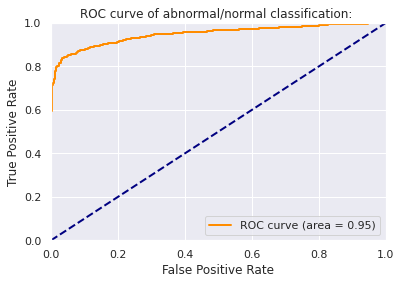

In [35]:
fpr_model,tpr_model=test(model,dataloaders['test'])

2021-12-31 06:18:03.556675


              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       677
         1.0       0.94      0.88      0.91       667

    accuracy                           0.91      1344
   macro avg       0.92      0.91      0.91      1344
weighted avg       0.92      0.91      0.91      1344

Test Accuracy: 0.9144  Test AUC: 0.9690  Test_AP: 0.9743
TP: 589  FP: 37  TN: 640  FN: 78
Sensitivity: 0.8831  Specificity: 0.9453
Precision: 94.09%  Recall: 88.31%  F1: 0.9111
PPV: 0.9409  NPV: 0.8914


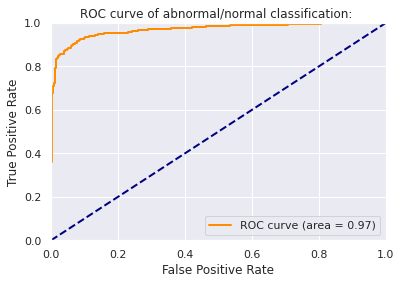

In [68]:
fpr_model,tpr_model=test(base_model,dataloaders['test'])